In [5]:

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


In [6]:
# Parameters
J = 1                # Interaction strength
h = -0.001         # Transverse magnetic field in X
Bz = 0.000176            # Magnetic field in Z
Bx = h               # Alias for transverse field
omega = 1.786e10         # External driving frequency
A = 1                # Driving amplitude
alpha = 0.1745          # Additional phase/angle parameter for tuning driving
pump_energy = 0.0003    # Total energy associated with the pump
L = 3                # Grid size (3x3 lattice)



In [7]:
# Define basic operators
sigma_x = qt.sigmax()
sigma_z = qt.sigmaz()
identity = qt.qeye(2)

# Initial 2D lattice state: all spins up
def create_2d_lattice_state(L):
    return [qt.basis(2, 0) for _ in range(L * L)]




In [8]:
# Interaction Hamiltonian
H_interaction = 0
for i in range(L):
    for j in range(L):
        neighbors = [((i + 1) % L, j), (i, (j + 1) % L)]
        for neighbor in neighbors:
            ops = [identity] * (L * L)
            ops[i * L + j] = sigma_z
            ops[neighbor[0] * L + neighbor[1]] = sigma_z
            H_interaction += J * qt.tensor(ops)

# Transverse field (X) + Magnetic field in Z
H_field = 0
for i in range(L):
    for j in range(L):
        idx = i * L + j
        op_x = [identity] * (L * L)
        op_z = [identity] * (L * L)
        op_x[idx] = sigma_x
        op_z[idx] = sigma_z
        H_field += Bx * qt.tensor(op_x)
        H_field += Bz * qt.tensor(op_z)

# Time-dependent drive operator
H_drive_op = 0
for i in range(L):
    for j in range(L):
        idx = i * L + j
        op = [identity] * (L * L)
        op[idx] = sigma_x
        H_drive_op += qt.tensor(op)



In [9]:
# Time-dependent coefficient
def drive_coeff(t, args):
    A = args['A']
    omega = args['omega']
    alpha = args['alpha']
    pump_energy = args['pump_energy']
    return pump_energy * A * np.cos(omega * t + alpha)

# Total Hamiltonian list
H_list = [H_interaction, H_field, [H_drive_op, drive_coeff]]

# Time array
tlist = np.linspace(0, 10, 8000)

# Initial state
initial_state = qt.tensor(create_2d_lattice_state(L))

# Observables (σ_z at each site)
observables = [qt.tensor([sigma_z if (ii == i and jj == j) else identity
                          for ii, jj in np.ndindex(L, L)])
               for i, j in np.ndindex(L, L)]

# Solve time evolution
result = qt.mesolve(H_list, initial_state, tlist, [], observables,
                    args={'A': A, 'omega': omega, 'alpha': alpha, 'pump_energy': pump_energy})



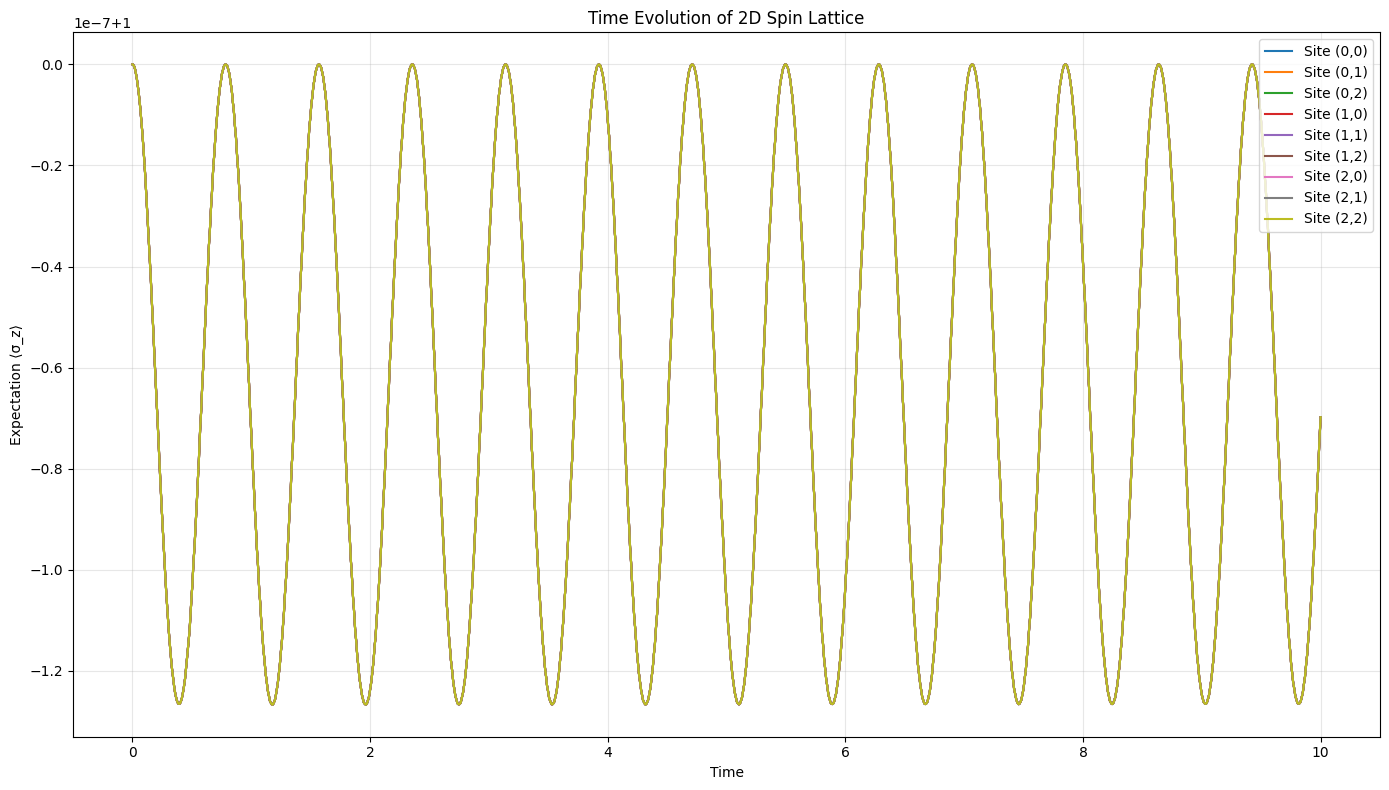

In [11]:
# Plot expectation values over time
plt.figure(figsize=(14, 8))
for idx, (i, j) in enumerate(np.ndindex(L, L)):
    plt.plot(tlist, result.expect[idx], label=f"Site ({i},{j})")
plt.xlabel('Time')
plt.ylabel('Expectation ⟨σ_z⟩')
plt.title('Time Evolution of 2D Spin Lattice')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

